# 1. Contextualização

O dataset [Flight Price Prediction](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction) disponibilizado por [Shubham Bathwal](https://www.kaggle.com/shubhambathwal) contém dados de reservas aéreas obtidas do website "Easy My Trip". Os dados cobrem o período de 11 de Fevereiro até 31 de Março de 2022, com 300261 registros. 

### Features
|Coluna|Descrição|
|-------|--------|
|airline|A linha aérea do voo|
|flight|O código de identificação do voo|
|source_city|A cidade de onde o voo está partindo|
|departure_time|Período do dia em qual o voo partiu|
|stops|Número de paradas entre a partida e o destino|
|arrival_time|Período do dia em que o voo chegou|
|destination_city|A cidade destino do voo|
|class|Classe do voo|
|duration|Duração em horas do voo|
|days_left|Diferença entre o dia da viagem e da reserva|
|price|Preço da passagem|

## 1.1. Metas e objetivos

Este projeto tem objetivo de responder algumas perguntas de negócio e criar um modelo de Machine Learning para predição de preços de voos.

### Perguntas de negócio
1. Preço varia de acordo com a Linha Aérea? e com a Classe?
2. Como os preços das passagens são afetados, entre 1 e 2 dias antes da viagem?
3. O preço muda de acordo com o período do dia para chegada e partida?
4. O preço muda de acordo com o destino de partida e chegada?

# 2. Preparação do ambiente

## 2.1. Importação das bibliotecas e carregamento dos dados

In [1]:
# Manipulação dos dados
import pandas as pd
import numpy as np

# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Machine Learning
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set2')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

In [2]:
df = pd.read_csv("../data/raw/Clean_Dataset.csv")

## 2.2. Qualidade dos dados

In [3]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 300153 linhas e 12 colunas.


In [4]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 8 colunas categóricas.
O dataset possui: 4 colunas numéricas.


In [5]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [6]:
df.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


# 3. Exploratory Data Analysis

## 3.1. Estatísticas descritivas

In [8]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.22,7.19,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.00,13.56,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.66,22697.77,1105.00,4783.00,7425.00,42521.00,123071.00


- Existe assimetria em ``price``, como a média é maior que a mediana é uma assimetria positiva;
- ``days_left`` tem uma distribuição normal;
- ``duration`` possui também assimetria positiva.

## 3.2. Dados nulos

In [9]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

## 3.3. O comportamento da variável alvo

In [10]:
print(f"Assimetria: {df.price.skew()}")
print(f"Curtose: {df.price.kurt()}")

Assimetria: 1.0613772532064343
Curtose: -0.3962927186960772


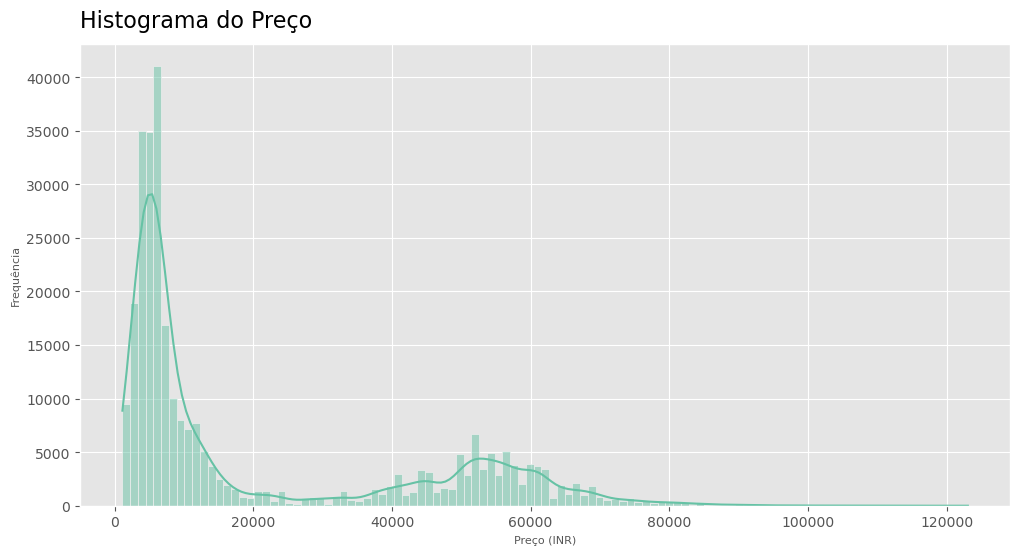

In [11]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.price, kde = True)
ax.set_title('Histograma do Preço', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Preço (INR)', fontsize = 8)
ax.set_ylabel('Frequência', fontsize = 8)
plt.show()

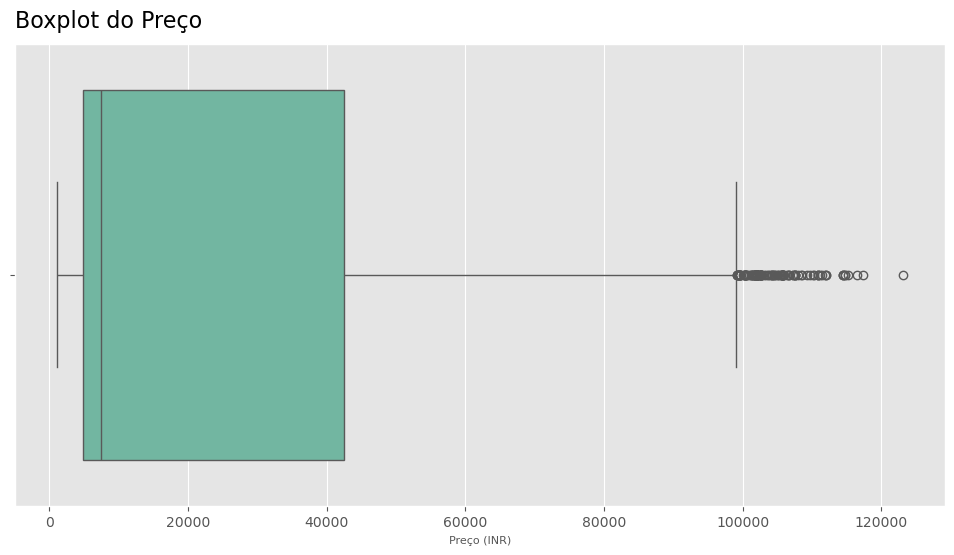

In [12]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.boxplot(df, x = df.price)
ax.set_title('Boxplot do Preço', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Preço (INR)', fontsize = 8)
plt.show()

### Target, features e as perguntas de negócio

#### 1. Preço varia de acordo com a Linha Aérea? e com a Classe?

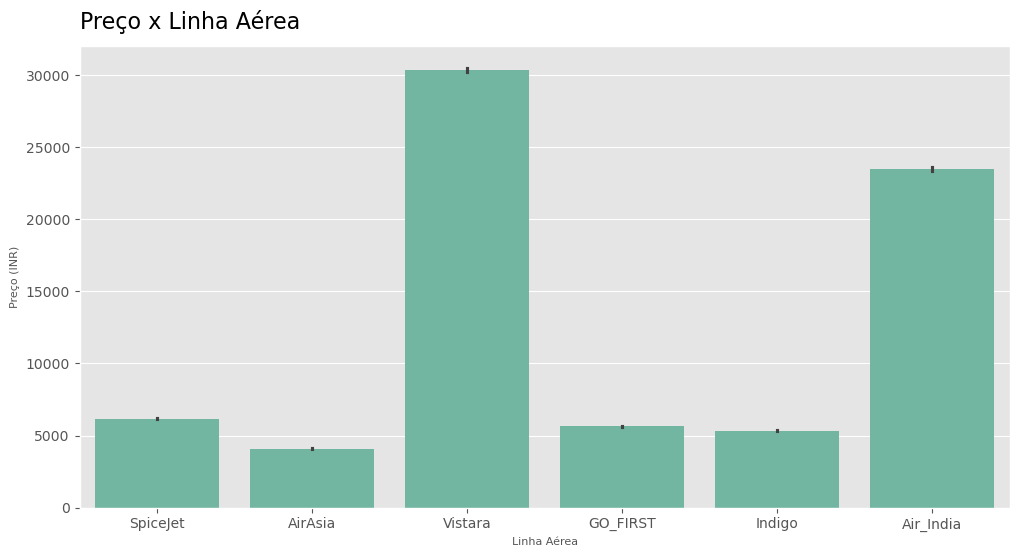

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df, x = df.airline, y = df.price)
ax.set_title('Preço x Linha Aérea', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Linha Aérea', fontsize = 8)
ax.set_ylabel('Preço (INR)', fontsize = 8)
plt.show()

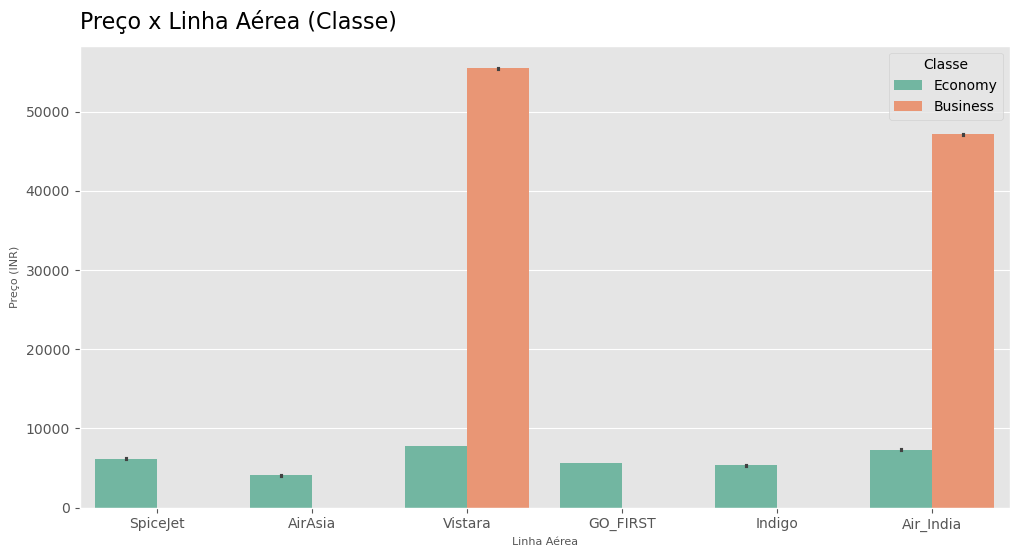

In [14]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df, x = df.airline, y = df.price, hue = df['class'])
ax.set_title('Preço x Linha Aérea (Classe)', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Linha Aérea', fontsize = 8)
ax.set_ylabel('Preço (INR)', fontsize = 8)
plt.legend(title = 'Classe')
plt.show()

Vistara e Air India são as únicas empreas que oferecem o voos de classe Executiva e por isso tem os maiores valores de passagem aérea. 

#### 2. Como os preços das passagens são afetados entre 1 e 2 dias antes da viagem?

In [15]:
def maior(i):
    if i > 2:
        return 'Mais de 2 dias'
    else:
        return 'Menos de 2 dias'

In [16]:
df_days = df.copy()
df_days['days'] = df['days_left'].apply(maior)

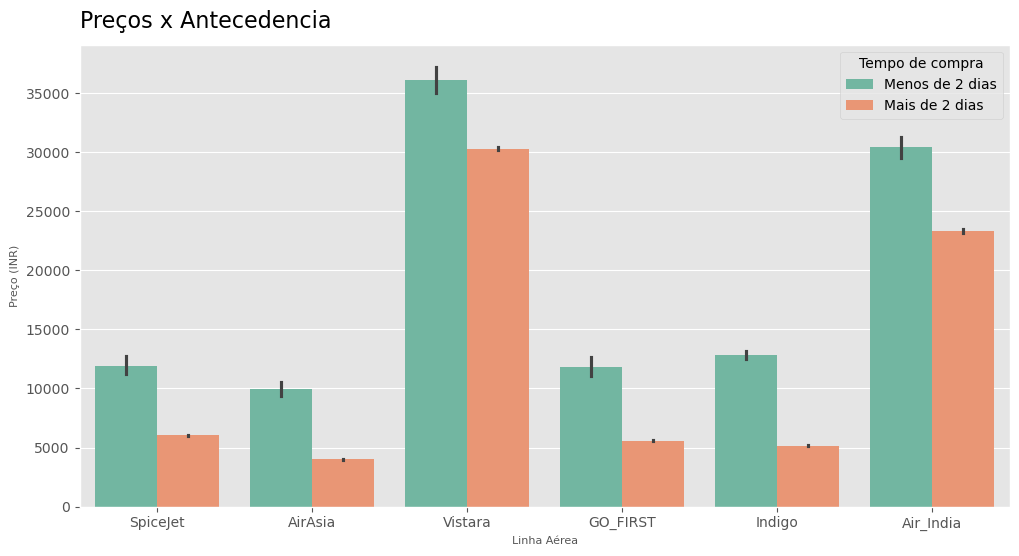

In [17]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(df_days, x = df_days.airline, y = df_days.price, hue = df_days.days)
ax.set_title("Preços x Antecedencia", loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel("Linha Aérea", fontsize = 8)
ax.set_ylabel("Preço (INR)", fontsize = 8)
plt.legend(title = 'Tempo de compra')
plt.show()

O preço de passagem aéreas tem tendência de serem maiores quanto mais próximo do voo.

#### 3. O preço muda de acordo com o período do dia para chegada e partida?

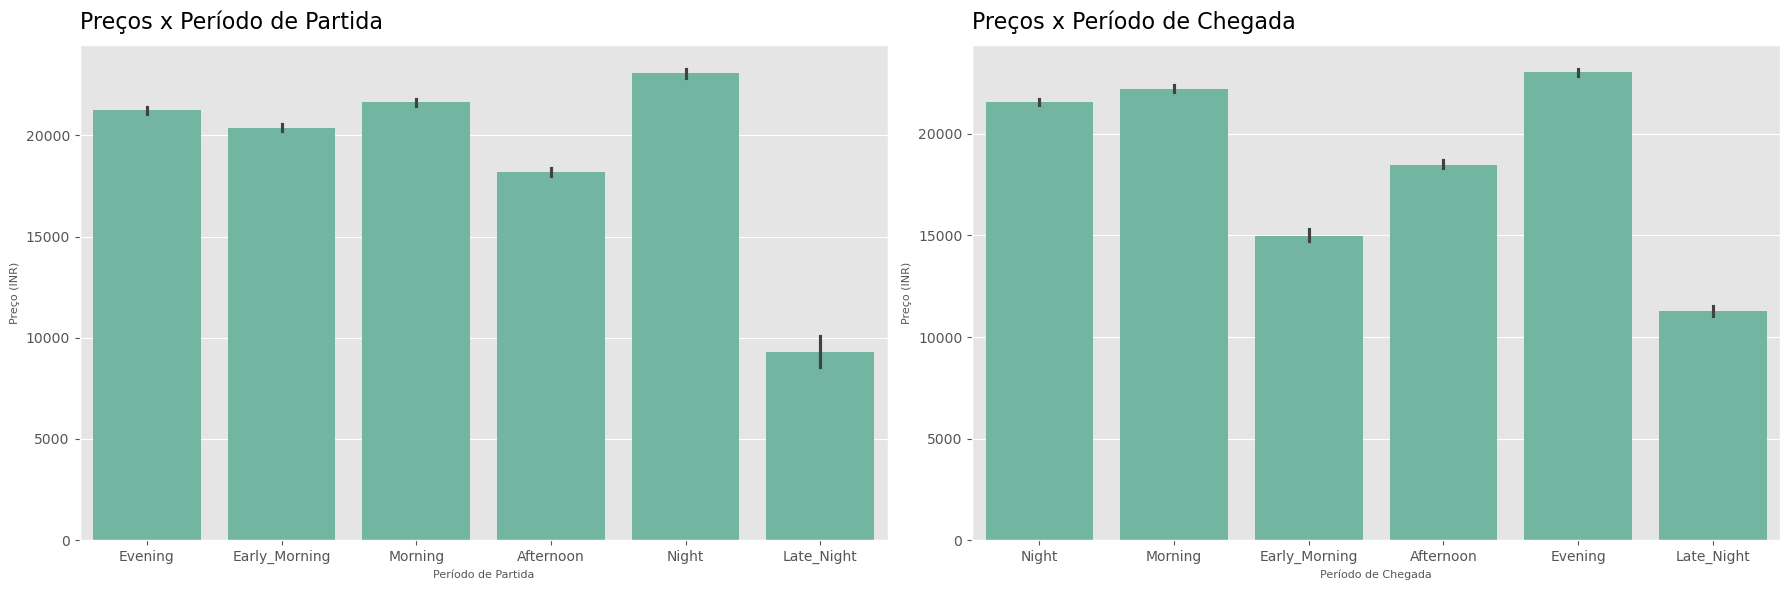

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

sns.barplot(ax = axes[0], data = df, x = df.departure_time, y = df.price)
axes[0].set_title("Preços x Período de Partida", loc = 'left', fontsize = 16, pad = 12)
axes[0].set_xlabel("Período de Partida", fontsize = 8)
axes[0].set_ylabel("Preço (INR)", fontsize = 8)

sns.barplot(ax = axes[1], data = df, x = df.arrival_time, y = df.price)
axes[1].set_title("Preços x Período de Chegada", loc = 'left', fontsize = 16, pad = 12)
axes[1].set_xlabel("Período de Chegada", fontsize = 8)
axes[1].set_ylabel("Preço (INR)", fontsize = 8)

plt.tight_layout()
plt.show()

A madrugada é o período onde se encontra as passagens mais baratas, já os voos a noite são os mais caros tanto para chegada quanto para partida. 

#### 4. O preço muda de acordo com o destino de partida e chegada?

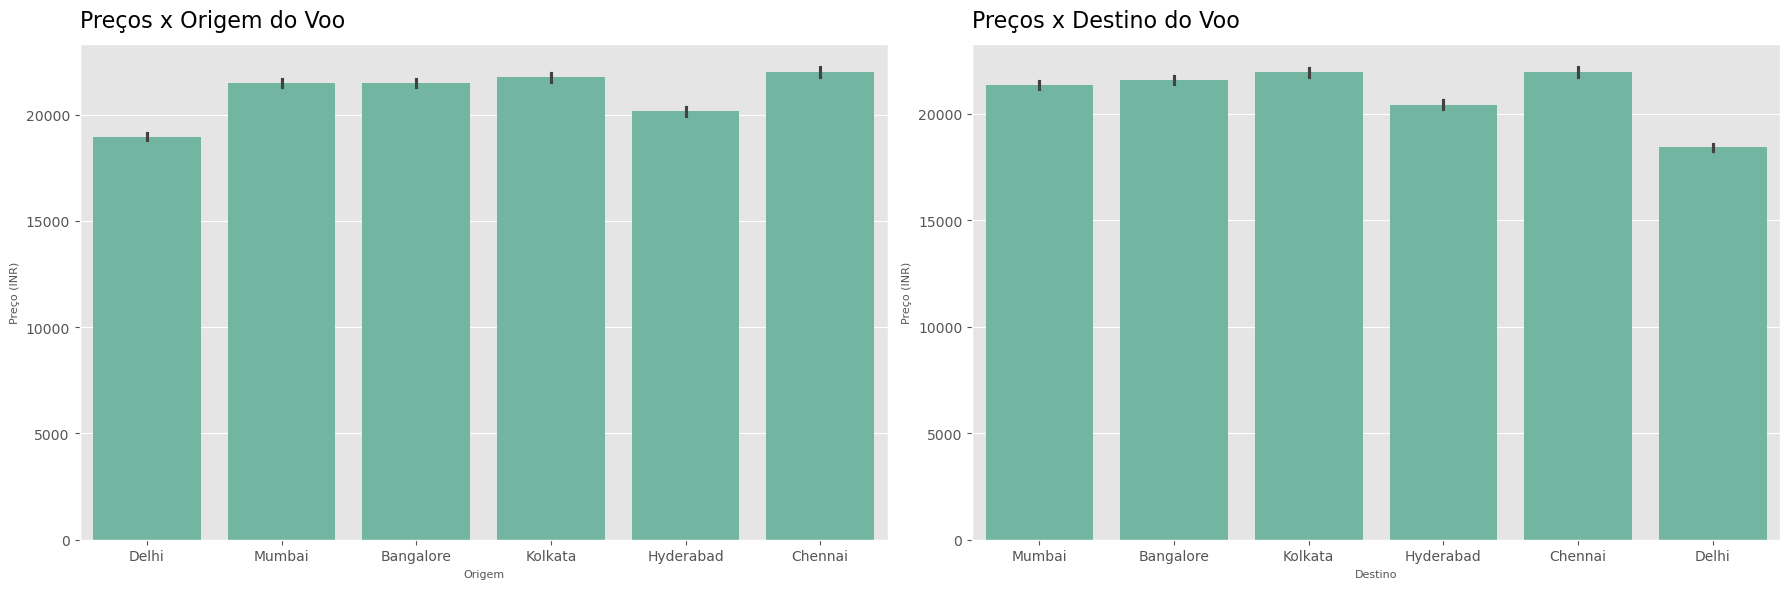

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

sns.barplot(ax = axes[0], data = df, x = df.source_city, y = df.price)
axes[0].set_title("Preços x Origem do Voo", loc = 'left', fontsize = 16, pad = 12)
axes[0].set_xlabel("Origem", fontsize = 8)
axes[0].set_ylabel("Preço (INR)", fontsize = 8)

sns.barplot(ax = axes[1], data = df, x = df.destination_city, y = df.price)
axes[1].set_title("Preços x Destino do Voo", loc = 'left', fontsize = 16, pad = 12)
axes[1].set_xlabel("Destino", fontsize = 8)
axes[1].set_ylabel("Preço (INR)", fontsize = 8)

plt.tight_layout()
plt.show()

Sim, os pontos de partida e destino tem influência no preço. Delhi é o destino mais barato, seguido por Hyderabad.

## 3.4. Matriz de correlação

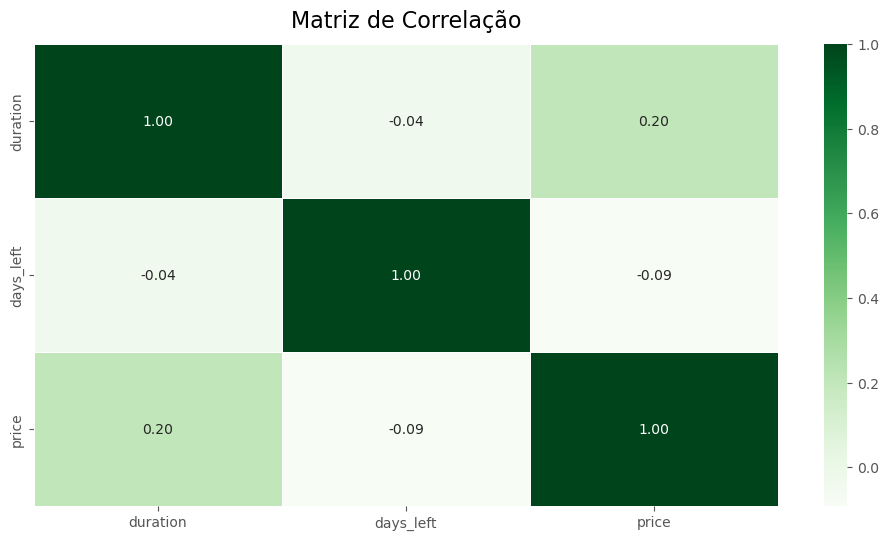

In [31]:
corr = df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', linecolor='white', linewidths=0.5, cmap = 'Greens')
ax.set_title('Matriz de Correlação', fontsize = 16, pad = 12)
plt.show()

# 4. Preparação dos dados

## 4.1. Seleção das features

In [21]:
features = df.drop(columns = ['flight', 'price'], axis = 1).columns.to_list()
target = 'price'

cat_features = df[features].select_dtypes(include = 'object').columns.to_list()
num_features = df[features].select_dtypes(include = 'number').columns.to_list()

print(f"Features categóricas: \n{cat_features}")
print(f"Features numéricas: \n{num_features}")

Features categóricas: 
['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
Features numéricas: 
['duration', 'days_left']


## 4.2. Split em treino e teste

In [22]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f"Média de preço em treino: {y_train.mean()}")
print(f"Média de preço em teste: {y_test.mean()}")

(240122, 9) (60031, 9) (240122,) (60031,)
Média de preço em treino: 20888.572417354513
Média de preço em teste: 20894.0129099965


## 4.3. Definição das etapas de pré-processamento

In [23]:
cat_transformer = Pipeline([
    ('cat_imputation', CategoricalImputer(imputation_method='frequent')),
    ('encoder', OneHotEncoder())
])

num_transformer = Pipeline([
    ('cat_imputer', MeanMedianImputer(imputation_method='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# 5. Modelo de Regressão

O modelo escolhido para o projeto será o XGBRegressor da biblioteca XGBoost

## 5.1. Pipeline do modelo e predições

In [24]:
model = XGBRegressor(objective='reg:squarederror', random_state = 42)

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputation',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   MeanMedianImputer())]),
                                                  ['duration...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [25]:
y_pred_train = xgb.predict(X_train)
y_pred = xgb.predict(X_test)

## 5.2. Métricas e avaliação do modelo

In [26]:
def metrics_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared = False)
    r2 = r2_score(y_true, y_pred)

    return {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'R2 Score': r2
    }

In [27]:
metrics_report(y_train, y_pred_train)

{'Mean Absolute Error': 1927.9153009399533,
 'Mean Squared Error': 11145408.12820081,
 'Root Mean Squared Error': 3338.473922048937,
 'R2 Score': 0.978363181835903}

In [28]:
metrics_report(y_test, y_pred)

{'Mean Absolute Error': 1990.967203354947,
 'Mean Squared Error': 12074863.988854643,
 'Root Mean Squared Error': 3474.8905002682664,
 'R2 Score': 0.9765755980215266}

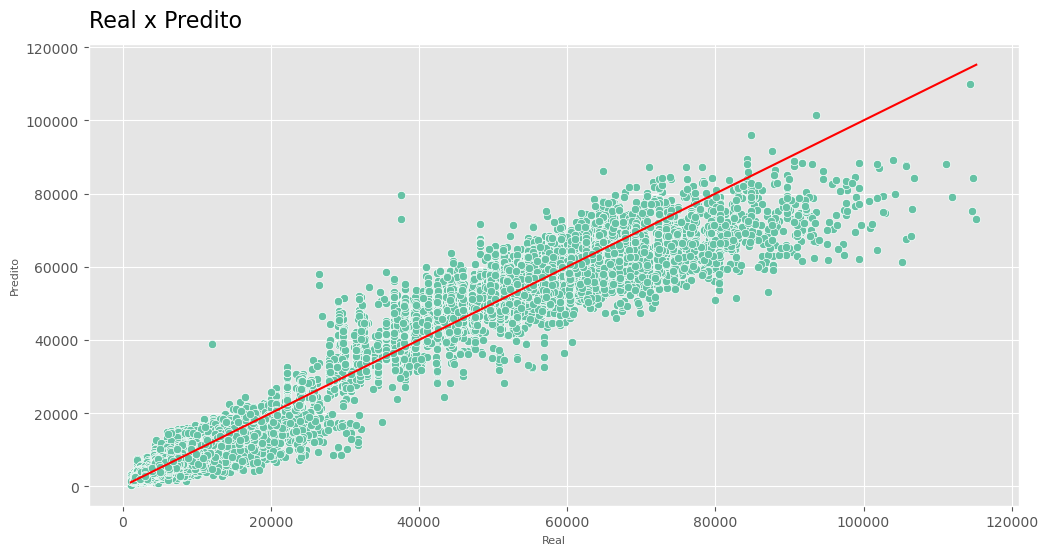

In [29]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred)
ax.set_title('Real x Predito', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Real', fontsize = 8)
ax.set_ylabel('Predito', fontsize = 8)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
plt.show()

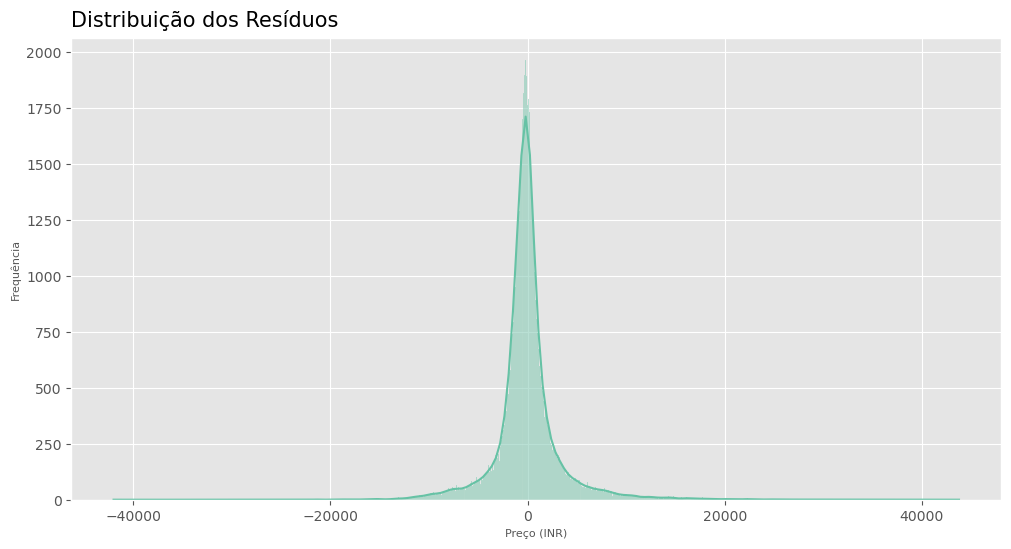

In [30]:
residuos = y_test - y_pred

fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(residuos, kde = True)
ax.set_title("Distribuição dos Resíduos", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Preço (INR)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize =8)
plt.show()

## 5.3. Tuning dos Hiper Parâmetros

In [40]:
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(**params))
    ])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [41]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-08-05 17:22:59,879] A new study created in memory with name: no-name-83d2f74b-b057-4bfa-98cd-7e3884028bef
[I 2024-08-05 17:23:42,466] Trial 0 finished with value: 4683.811556003953 and parameters: {'learning_rate': 0.007377226992126731, 'max_depth': 8, 'subsample': 0.41853738000316726, 'colsample_bytree': 0.2647296469746868, 'min_child_weight': 2}. Best is trial 0 with value: 4683.811556003953.
[I 2024-08-05 17:24:17,196] Trial 1 finished with value: 8417.64945704747 and parameters: {'learning_rate': 0.0012789203723276577, 'max_depth': 7, 'subsample': 0.41727685770498774, 'colsample_bytree': 0.7024446776481745, 'min_child_weight': 5}. Best is trial 0 with value: 4683.811556003953.
[I 2024-08-05 17:24:36,670] Trial 2 finished with value: 5039.805372067178 and parameters: {'learning_rate': 0.0113371321560956, 'max_depth': 3, 'subsample': 0.27364754932786156, 'colsample_bytree': 0.33319058937362717, 'min_child_weight': 3}. Best is trial 0 with value: 4683.811556003953.
[I 2024-08-

In [42]:
print('Melhores hiper parâmetros:', study.best_params)
print('Melhor resultado de RMSE:', study.best_value)

Melhores hiper parâmetros: {'learning_rate': 0.09372862218041428, 'max_depth': 10, 'subsample': 0.7358527060931693, 'colsample_bytree': 0.9494020324700931, 'min_child_weight': 7}
Melhor resultado de RMSE: 2406.245267573976


In [46]:
best_params = study.best_params

In [52]:
best_params

{'learning_rate': 0.09372862218041428,
 'max_depth': 10,
 'subsample': 0.7358527060931693,
 'colsample_bytree': 0.9494020324700931,
 'min_child_weight': 7}

### Predições e métricas pós-tuning

In [47]:
model = XGBRegressor(**best_params)

xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imputation',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class']),
                                                 ('num',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   MeanMedianImputer())]),
                                                  ['duration...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09372862218041428, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=7, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [48]:
y_pred = xgb.predict(X_test)
metrics_report(y_test, y_pred)

{'Mean Absolute Error': 1588.4280759902874,
 'Mean Squared Error': 8835481.460469361,
 'Root Mean Squared Error': 2972.453777684249,
 'R2 Score': 0.9828597763424568}

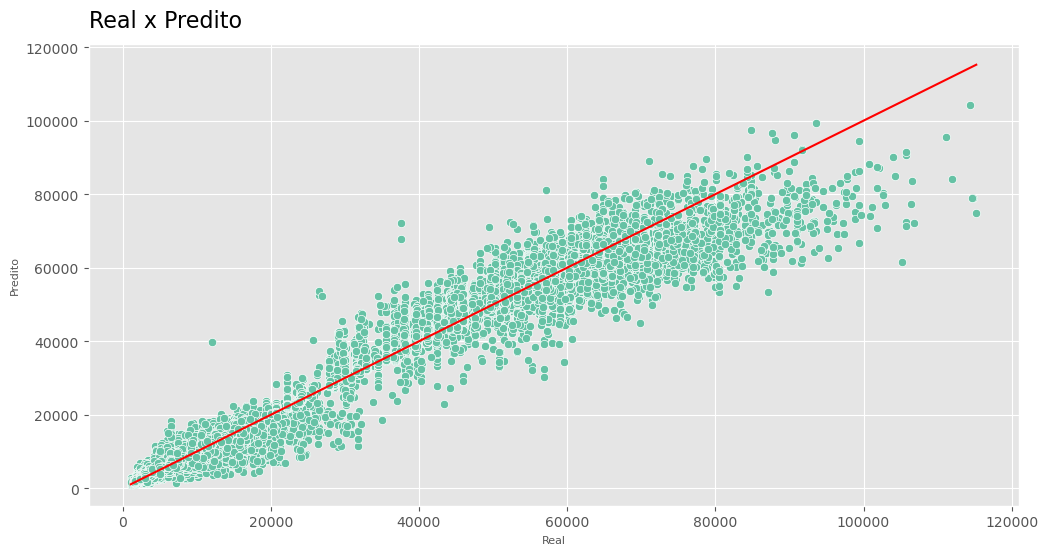

In [50]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred)
ax.set_title('Real x Predito', loc = 'left', fontsize = 16, pad = 12)
ax.set_xlabel('Real', fontsize = 8)
ax.set_ylabel('Predito', fontsize = 8)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red')
plt.show()

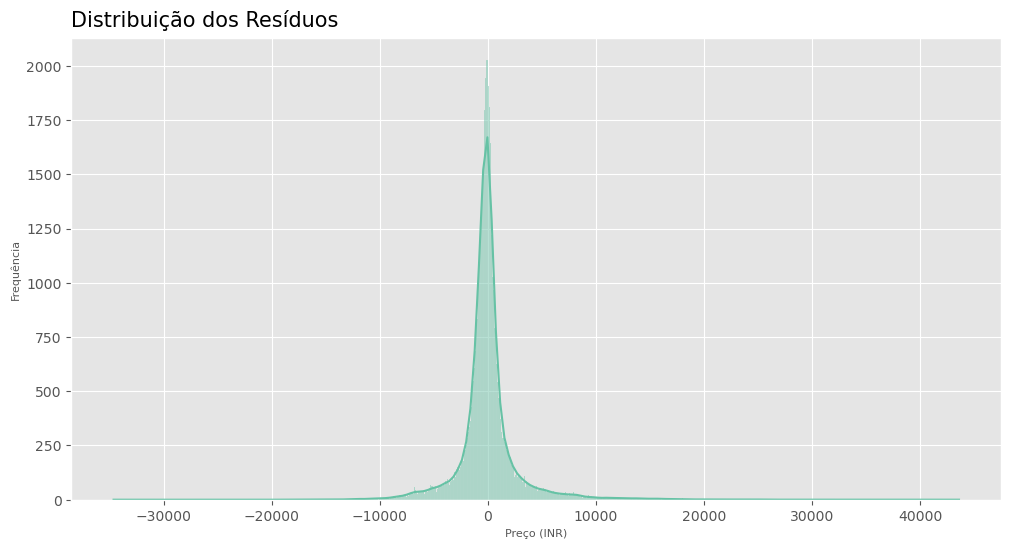

In [51]:
residuos = y_test - y_pred

fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(residuos, kde = True)
ax.set_title("Distribuição dos Resíduos", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Preço (INR)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize =8)
plt.show()